In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


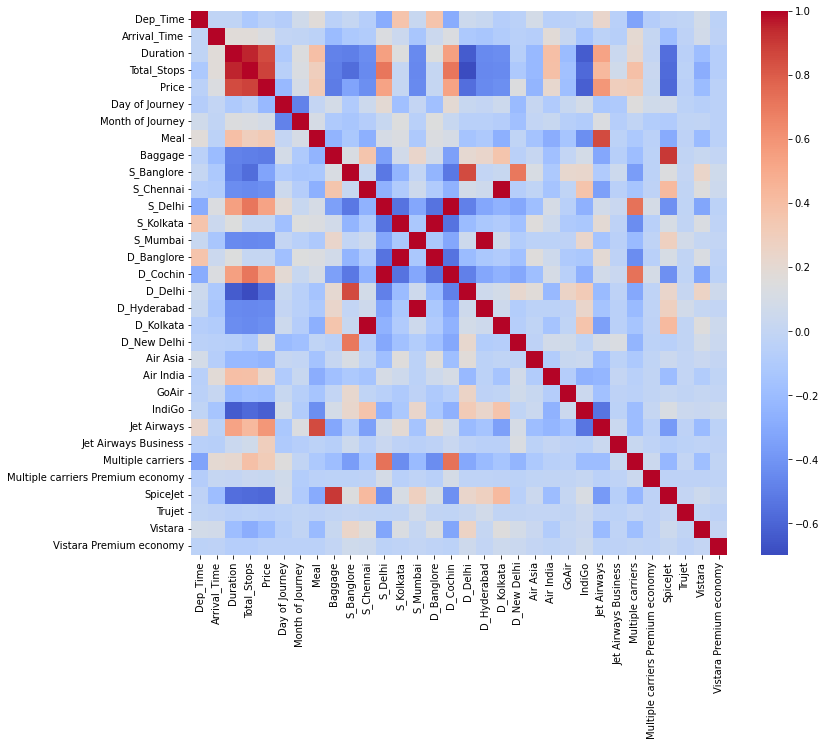

In [82]:
def preprocess_inputs(df):

    df = df.copy()
   

    # Drop Route
    df = df.drop(['Route'], axis=1)
    
    # Extract Days and Months from Date of journey
    df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])
    df['Day of Journey'] = df['Date_of_Journey'].dt.day
    df['Month of Journey'] = df['Date_of_Journey'].dt.month
    df = df.drop('Date_of_Journey', axis=1)
   
    
    # Convert and encode departure and arrival time to 4 different times of the day (morning, noon, afternoon, evening)
    df['Dep_Time'] = pd.to_datetime(df['Dep_Time'])
    df['Dep_Time'] = df['Dep_Time'].apply(lambda x: (int)(x.hour/6))
    df['Arrival_Time'] = pd.to_datetime(df['Arrival_Time'])
    df['Arrival_Time'] = df['Arrival_Time'].apply(lambda x: (int)(x.hour/6))
    
    # Duration converting to minutes
    df['H'] = df['Duration'].str.extract(r'(\d*(?=h))')
    df['M'] = df['Duration'].str.extract(r'(\d*(?=m))')
    df[['H', 'M']] = df[['H', 'M']].fillna(0)
    df[['H', 'M']] = df[['H', 'M']].astype(int)
    df['Duration'] = df['H'] * 60 + df['M']
    df = df.drop(['H', 'M'], axis=1)
    


    # Features from Additional info and total stops 
    
    df['Total_Stops']=df['Total_Stops'].map({'non-stop':0 ,'1 stop':1 ,'2 stops':2,'3 stops':3,'4 stops':4})
    df['Meal'] = df['Additional_Info'].map({'In-flight meal not included':1, 'No info':0})
    df['Baggage'] = df['Additional_Info'].map({'No check-in baggage included':1,'No info':0 })
    df = df.drop('Additional_Info', axis=1)
    
    
    # Source, Destination and Airline encoding (One-hot)
    df = pd.concat([df, pd.get_dummies(df['Source'], prefix='S')], axis=1)
    df = pd.concat([df, pd.get_dummies(df['Destination'], prefix='D')], axis=1)
    df = pd.concat([df, pd.get_dummies(df['Airline'])], axis=1)
    df = df.drop(['Source', 'Destination','Airline'], axis=1)
   
    df = df.fillna(0) #to avoid null values 
    
    
    #exploratory data analysis
    corr = df.corr() #to see the correlation between each feature and the price 
    plt.figure(figsize=(12,10))
    sns.heatmap(corr.corr(),cmap = 'coolwarm', annot=False)
   
    # Split X and y
    X = df.drop(['Price'], axis=1)
    y = np.log(df['Price'])
    

    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle = True, random_state = 0)
    
    
    return X_train, X_test, y_train, y_test

data = pd.read_excel('Data_Train.xlsx')

X_train, X_test, y_train, y_test = preprocess_inputs(data)



      Dep_Time  Arrival_Time  Duration  Total_Stops  Day of Journey  \
508          3             3      1350          1.0              21   
3071         1             2       470          1.0              24   
2036         3             1       695          1.0               3   
49           3             3      1195          2.0              27   
9686         3             0       155          0.0              27   
...        ...           ...       ...          ...             ...   
9225         1             0      1330          1.0               6   
4859         3             3      1275          2.0               6   
3264         1             0      1225          1.0               3   
9845         1             2      1505          1.0              18   
2732         3             3      1630          1.0               5   

      Month of Journey  Meal  Baggage  S_Banglore  S_Chennai  ...  GoAir  \
508                  5   0.0      0.0           0          0  ...      

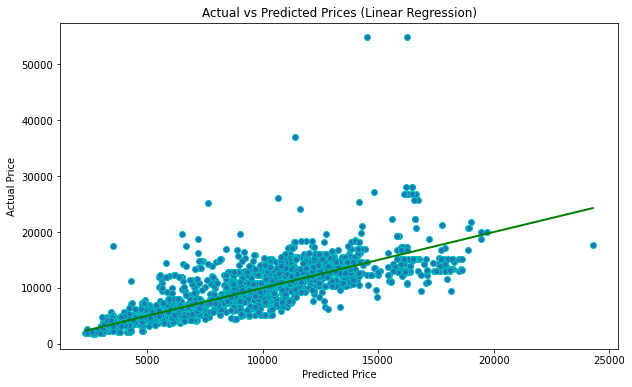

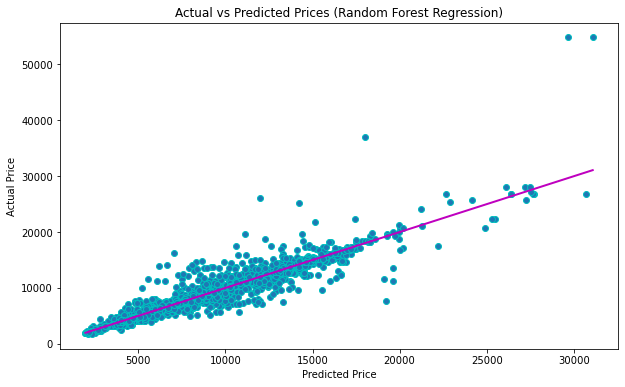

In [83]:
print(X_train)

models = {
    "Random Forest" : RandomForestRegressor(),
    "Linear ": LinearRegression() 
}

print("-------- Training --------")
for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained!")
print("---------- Done ----------")

y_test = np.exp(y_test)

for name, model in models.items():
    y_pred = np.exp(model.predict(X_test))

    print(name + ": R2 Score = {:.4f}".format(r2_score(y_test, y_pred)))
    print("                   RMSE = {:.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
    print("                    MAE = {:.0f}".format(mean_absolute_error(y_test, y_pred)))
    print("                   MAPE = {:.2f} %\n".format(mean_absolute_percentage_error(y_test, y_pred) * 100))

# Random Forest predictions
y_pred_linear = np.exp(models['Linear '].predict(X_test))
y_pred_forest = np.exp(models['Random Forest'].predict(X_test))

# Display Linear Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_linear, y_test, edgecolor='c')
plt.plot([y_pred_linear.min(), y_pred_linear.max()], [y_pred_linear.min(), y_pred_linear.max()], c='g', lw=2)
plt.title("Actual vs Predicted Prices (Linear Regression)")
plt.xlabel("Predicted Price")
plt.ylabel("Actual Price")
plt.show()


# Display Random Forest Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_forest, y_test, edgecolor='c')
plt.plot([y_pred_forest.min(), y_pred_forest.max()], [y_pred_forest.min(), y_pred_forest.max()], c='m', lw=2)
plt.title("Actual vs Predicted Prices (Random Forest Regression)")
plt.xlabel("Predicted Price")
plt.ylabel("Actual Price")
plt.show()
